Training on the Lall dataset.

In [7]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data Loading

In [8]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_Lall.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_L.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_L.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


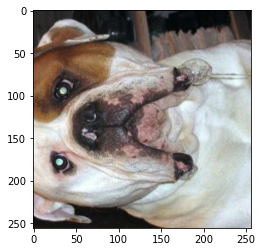

In [9]:
train_b1_img, train_b1_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model with 6 conv layers

In [11]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)

learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 90

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(64, 128,

Epoch:7
Iteration:1400
Time taken for the last 50 iterations: 36.24221324920654
Current training loss:3.002028226852417
Current training accuracy:0.1640625
Current validation loss:3.0492148399353027
Current validation accuracy:0.16104461252689362
Epoch:7
Iteration:1450
Time taken for the last 50 iterations: 36.017863512039185
Current training loss:3.0097341537475586
Current training accuracy:0.169921875
Current validation loss:3.105563163757324
Current validation accuracy:0.14907507598400116
Epoch:8
Iteration:1500
Time taken for the last 50 iterations: 35.983842611312866
Current training loss:3.038046360015869
Current training accuracy:0.14697265625
Current validation loss:3.1176791191101074
Current validation accuracy:0.12948857247829437
Epoch:8
Iteration:1550
Time taken for the last 50 iterations: 36.03951597213745
Current training loss:2.996734142303467
Current training accuracy:0.16943359375
Current validation loss:3.0806360244750977
Current validation accuracy:0.14472252130508423


Epoch:16
Iteration:3050
Time taken for the last 50 iterations: 34.87130665779114
Current training loss:2.4269778728485107
Current training accuracy:0.30712890625
Current validation loss:2.6107094287872314
Current validation accuracy:0.2578890025615692
Epoch:16
Iteration:3100
Time taken for the last 50 iterations: 34.9899377822876
Current training loss:2.441056251525879
Current training accuracy:0.326171875
Current validation loss:2.6009979248046875
Current validation accuracy:0.2611534297466278
Epoch:16
Iteration:3150
Time taken for the last 50 iterations: 34.954623222351074
Current training loss:2.403669595718384
Current training accuracy:0.3271484375
Current validation loss:2.5922391414642334
Current validation accuracy:0.26877039670944214
Epoch:17
Iteration:3200
Time taken for the last 50 iterations: 34.22086024284363
Current training loss:2.4321441650390625
Current training accuracy:0.3232421875
Current validation loss:2.614961862564087
Current validation accuracy:0.280739933252334

Epoch:25
Iteration:4700
Time taken for the last 50 iterations: 34.92276477813721
Current training loss:2.1624844074249268
Current training accuracy:0.38623046875
Current validation loss:2.4112231731414795
Current validation accuracy:0.30250272154808044
Epoch:25
Iteration:4750
Time taken for the last 50 iterations: 34.93103337287903
Current training loss:2.027137279510498
Current training accuracy:0.45751953125
Current validation loss:2.281981945037842
Current validation accuracy:0.33949944376945496
Epoch:25
Iteration:4800
Time taken for the last 50 iterations: 34.42048120498657
Current training loss:2.064373731613159
Current training accuracy:0.453125
Current validation loss:2.351508617401123
Current validation accuracy:0.3177366554737091
Epoch:26
Iteration:4850
Time taken for the last 50 iterations: 34.14677834510803
Current training loss:2.0151009559631348
Current training accuracy:0.4384765625
Current validation loss:2.3287906646728516
Current validation accuracy:0.3275299370288849


Epoch:34
Iteration:6350
Time taken for the last 50 iterations: 34.76500582695007
Current training loss:1.8977388143539429
Current training accuracy:0.48974609375
Current validation loss:2.247772216796875
Current validation accuracy:0.3438520133495331
Epoch:34
Iteration:6400
Time taken for the last 50 iterations: 35.43757390975952
Current training loss:1.822668194770813
Current training accuracy:0.52294921875
Current validation loss:2.2079384326934814
Current validation accuracy:0.35255712270736694
Epoch:34
Iteration:6450
Time taken for the last 50 iterations: 34.61418867111206
Current training loss:1.8250659704208374
Current training accuracy:0.50146484375
Current validation loss:2.246202230453491
Current validation accuracy:0.3503808379173279
Epoch:34
Iteration:6500
Time taken for the last 50 iterations: 34.90897226333618
Current training loss:1.8547123670578003
Current training accuracy:0.4931640625
Current validation loss:2.258147716522217
Current validation accuracy:0.3286180496215

Epoch:43
Iteration:8000
Time taken for the last 50 iterations: 34.74993085861206
Current training loss:1.6920232772827148
Current training accuracy:0.54150390625
Current validation loss:2.217663526535034
Current validation accuracy:0.3601740896701813
Epoch:43
Iteration:8050
Time taken for the last 50 iterations: 35.48147678375244
Current training loss:1.6332932710647583
Current training accuracy:0.57666015625
Current validation loss:2.1336305141448975
Current validation accuracy:0.3754080533981323
Epoch:43
Iteration:8100
Time taken for the last 50 iterations: 35.21518349647522
Current training loss:1.5515586137771606
Current training accuracy:0.5966796875
Current validation loss:2.1150474548339844
Current validation accuracy:0.36561480164527893
Epoch:43
Iteration:8150
Time taken for the last 50 iterations: 35.53320050239563
Current training loss:1.5962468385696411
Current training accuracy:0.58154296875
Current validation loss:2.1440775394439697
Current validation accuracy:0.3699673414

Current validation loss:2.091505765914917
Current validation accuracy:0.3884657323360443
Epoch:51
Iteration:9650
Time taken for the last 50 iterations: 35.39593052864075
Current training loss:1.4573893547058105
Current training accuracy:0.64599609375
Current validation loss:2.081423044204712
Current validation accuracy:0.3873775899410248
Epoch:52
Iteration:9700
Time taken for the last 50 iterations: 35.100791454315186
Current training loss:1.4805536270141602
Current training accuracy:0.62841796875
Current validation loss:2.0858116149902344
Current validation accuracy:0.3873775899410248
Epoch:52
Iteration:9750
Time taken for the last 50 iterations: 35.628138065338135
Current training loss:1.478402853012085
Current training accuracy:0.6201171875
Current validation loss:2.1005430221557617
Current validation accuracy:0.38955387473106384
Epoch:52
Iteration:9800
Time taken for the last 50 iterations: 35.544305086135864
Current training loss:1.4498744010925293
Current training accuracy:0.6533

Current training loss:1.3001352548599243
Current training accuracy:0.6845703125
Current validation loss:2.0105254650115967
Current validation accuracy:0.4047878086566925
Epoch:60
Iteration:11300
Time taken for the last 50 iterations: 36.16402769088745
Current training loss:1.3542444705963135
Current training accuracy:0.68505859375
Current validation loss:2.0384268760681152
Current validation accuracy:0.39934712648391724
Epoch:61
Iteration:11350
Time taken for the last 50 iterations: 34.67278790473938
Current training loss:1.3382776975631714
Current training accuracy:0.69482421875
Current validation loss:1.9840292930603027
Current validation accuracy:0.40696409344673157
Epoch:61
Iteration:11400
Time taken for the last 50 iterations: 35.773324728012085
Current training loss:1.3896723985671997
Current training accuracy:0.6552734375
Current validation loss:2.0205554962158203
Current validation accuracy:0.40587595105171204
Epoch:61
Iteration:11450
Time taken for the last 50 iterations: 35.8

Epoch:69
Iteration:12900
Time taken for the last 50 iterations: 35.65351176261902
Current training loss:1.2532747983932495
Current training accuracy:0.69384765625
Current validation loss:2.016033887863159
Current validation accuracy:0.4243743121623993
Epoch:69
Iteration:12950
Time taken for the last 50 iterations: 35.864227533340454
Current training loss:1.2374365329742432
Current training accuracy:0.72265625
Current validation loss:2.013577938079834
Current validation accuracy:0.41675734519958496
Epoch:69
Iteration:13000
Time taken for the last 50 iterations: 35.07338094711304
Current training loss:1.20547616481781
Current training accuracy:0.7265625
Current validation loss:2.0440423488616943
Current validation accuracy:0.4047878086566925
Epoch:70
Iteration:13050
Time taken for the last 50 iterations: 35.08991599082947
Current training loss:1.1766777038574219
Current training accuracy:0.7412109375
Current validation loss:2.031571388244629
Current validation accuracy:0.4080522358417511

Current validation loss:1.996376633644104
Current validation accuracy:0.4276387393474579
Epoch:78
Iteration:14550
Time taken for the last 50 iterations: 34.90743803977966
Current training loss:1.1278505325317383
Current training accuracy:0.75
Current validation loss:1.9711686372756958
Current validation accuracy:0.42328616976737976
Epoch:78
Iteration:14600
Time taken for the last 50 iterations: 35.60872220993042
Current training loss:1.1648919582366943
Current training accuracy:0.73486328125
Current validation loss:2.023249387741089
Current validation accuracy:0.41022852063179016
Epoch:78
Iteration:14650
Time taken for the last 50 iterations: 35.37674069404602
Current training loss:1.1701886653900146
Current training accuracy:0.7509765625
Current validation loss:2.0042614936828613
Current validation accuracy:0.42002177238464355
Epoch:79
Iteration:14700
Time taken for the last 50 iterations: 34.8390371799469
Current training loss:1.1209546327590942
Current training accuracy:0.7797851562

Current training loss:1.076254963874817
Current training accuracy:0.79296875
Current validation loss:1.9792805910110474
Current validation accuracy:0.4287268817424774
Epoch:87
Iteration:16200
Time taken for the last 50 iterations: 41.59255027770996
Current training loss:1.0248603820800781
Current training accuracy:0.7861328125
Current validation loss:1.9672462940216064
Current validation accuracy:0.4276387393474579
Epoch:87
Iteration:16250
Time taken for the last 50 iterations: 42.3118577003479
Current training loss:1.0680333375930786
Current training accuracy:0.7802734375
Current validation loss:1.978002667427063
Current validation accuracy:0.39934712648391724
Epoch:87
Iteration:16300
Time taken for the last 50 iterations: 41.827401876449585
Current training loss:1.0200471878051758
Current training accuracy:0.7802734375
Current validation loss:1.9284781217575073
Current validation accuracy:0.4243743121623993
Epoch:87
Iteration:16350
Time taken for the last 50 iterations: 41.4258430004

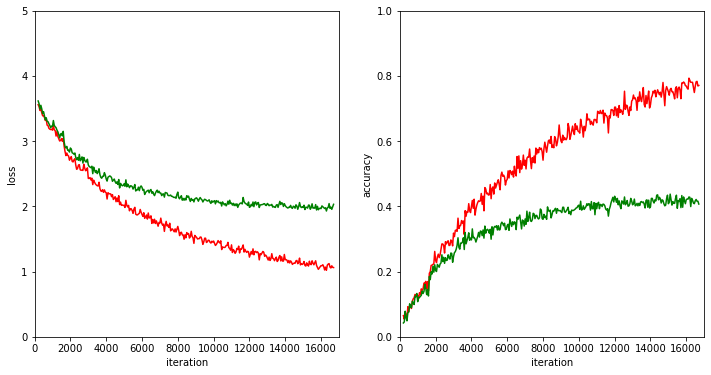

In [12]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,17000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,17000)
acc_graph.set_ylim(0,1)

plt.show() 

# Model with 6 conv and 2 dense layers

In [13]:
class PetCNN6ch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.4),
                                    nn.Linear(1024, 370))
        
        self.dense2 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(370, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)     
        out = self.dense1(out)
        out = self.dense2(out)
        out = nn.functional.log_softmax(out,dim=1)    
        
        return out
    


model1 = PetCNN6ch()
loss_function = nn.NLLLoss()


print(model1)
        


learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 90

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


PetCNN6ch(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 25

Current validation loss:2.8429529666900635
Current validation accuracy:0.21871599555015564
Epoch:7
Iteration:1400
Time taken for the last 50 iterations: 59.62431573867798
Current training loss:2.677136182785034
Current training accuracy:0.24072265625
Current validation loss:2.8207523822784424
Current validation accuracy:0.20021763443946838
Epoch:7
Iteration:1450
Time taken for the last 50 iterations: 60.05659031867981
Current training loss:2.6864099502563477
Current training accuracy:0.2353515625
Current validation loss:2.816845417022705
Current validation accuracy:0.20674645900726318
Epoch:8
Iteration:1500
Time taken for the last 50 iterations: 59.26530313491821
Current training loss:2.703524589538574
Current training accuracy:0.2451171875
Current validation loss:2.75785756111145
Current validation accuracy:0.22306855022907257
Epoch:8
Iteration:1550
Time taken for the last 50 iterations: 59.71871042251587
Current training loss:2.708784818649292
Current training accuracy:0.23095703125


Current validation loss:2.254551649093628
Current validation accuracy:0.34929269552230835
Epoch:16
Iteration:3050
Time taken for the last 50 iterations: 59.83489370346069
Current training loss:1.91010320186615
Current training accuracy:0.4521484375
Current validation loss:2.2738475799560547
Current validation accuracy:0.33623504638671875
Epoch:16
Iteration:3100
Time taken for the last 50 iterations: 59.80659341812134
Current training loss:1.8639994859695435
Current training accuracy:0.46923828125
Current validation loss:2.327118158340454
Current validation accuracy:0.33949944376945496
Epoch:16
Iteration:3150
Time taken for the last 50 iterations: 59.33193254470825
Current training loss:1.787301778793335
Current training accuracy:0.49560546875
Current validation loss:2.235077142715454
Current validation accuracy:0.3449401557445526
Epoch:17
Iteration:3200
Time taken for the last 50 iterations: 58.94226431846619
Current training loss:1.8250243663787842
Current training accuracy:0.48388671

Current validation loss:2.11506986618042
Current validation accuracy:0.3917301297187805
Epoch:25
Iteration:4700
Time taken for the last 50 iterations: 62.4909451007843
Current training loss:1.1448644399642944
Current training accuracy:0.7001953125
Current validation loss:2.0671138763427734
Current validation accuracy:0.39608269929885864
Epoch:25
Iteration:4750
Time taken for the last 50 iterations: 62.754077434539795
Current training loss:1.306794285774231
Current training accuracy:0.6455078125
Current validation loss:2.1295814514160156
Current validation accuracy:0.3917301297187805
Epoch:25
Iteration:4800
Time taken for the last 50 iterations: 82.05632472038269
Current training loss:1.1949715614318848
Current training accuracy:0.70556640625
Current validation loss:2.0827789306640625
Current validation accuracy:0.38955387473106384
Epoch:26
Iteration:4850
Time taken for the last 50 iterations: 59.7894651889801
Current training loss:1.197290062904358
Current training accuracy:0.698730468

Current training loss:0.7700700163841248
Current training accuracy:0.818359375
Current validation loss:2.0995216369628906
Current validation accuracy:0.4047878086566925
Epoch:34
Iteration:6350
Time taken for the last 50 iterations: 65.62745428085327
Current training loss:0.7758620381355286
Current training accuracy:0.84765625
Current validation loss:2.015197992324829
Current validation accuracy:0.43307942152023315
Epoch:34
Iteration:6400
Time taken for the last 50 iterations: 66.81381106376648
Current training loss:0.794243335723877
Current training accuracy:0.82666015625
Current validation loss:2.044301986694336
Current validation accuracy:0.418933629989624
Epoch:34
Iteration:6450
Time taken for the last 50 iterations: 68.42623662948608
Current training loss:0.7433184385299683
Current training accuracy:0.83984375
Current validation loss:2.0055387020111084
Current validation accuracy:0.4254624545574188
Epoch:34
Iteration:6500
Time taken for the last 50 iterations: 67.36771202087402
Cur

Current training loss:0.5140131115913391
Current training accuracy:0.90869140625
Current validation loss:2.0021626949310303
Current validation accuracy:0.4341675639152527
Epoch:43
Iteration:8000
Time taken for the last 50 iterations: 67.00011014938354
Current training loss:0.5098909139633179
Current training accuracy:0.90283203125
Current validation loss:2.0124194622039795
Current validation accuracy:0.4341675639152527
Epoch:43
Iteration:8050
Time taken for the last 50 iterations: 67.24753093719482
Current training loss:0.5286422967910767
Current training accuracy:0.90966796875
Current validation loss:2.0210564136505127
Current validation accuracy:0.4341675639152527
Epoch:43
Iteration:8100
Time taken for the last 50 iterations: 63.483447551727295
Current training loss:0.5264113545417786
Current training accuracy:0.908203125
Current validation loss:2.0342674255371094
Current validation accuracy:0.4472252428531647
Epoch:43
Iteration:8150
Time taken for the last 50 iterations: 52.18914747

Epoch:51
Iteration:9600
Time taken for the last 50 iterations: 54.621681928634644
Current training loss:0.39536210894584656
Current training accuracy:0.93359375
Current validation loss:2.0572643280029297
Current validation accuracy:0.42219802737236023
Epoch:51
Iteration:9650
Time taken for the last 50 iterations: 54.74389624595642
Current training loss:0.3393386900424957
Current training accuracy:0.9541015625
Current validation loss:2.04296612739563
Current validation accuracy:0.44287267327308655
Epoch:52
Iteration:9700
Time taken for the last 50 iterations: 53.77667212486267
Current training loss:0.3477936387062073
Current training accuracy:0.94873046875
Current validation loss:2.032123565673828
Current validation accuracy:0.4472252428531647
Epoch:52
Iteration:9750
Time taken for the last 50 iterations: 55.44692540168762
Current training loss:0.3943350911140442
Current training accuracy:0.9423828125
Current validation loss:2.090733766555786
Current validation accuracy:0.42437431216239

Current validation loss:2.107741117477417
Current validation accuracy:0.4287268817424774
Epoch:60
Iteration:11250
Time taken for the last 50 iterations: 68.1913673877716
Current training loss:0.29183802008628845
Current training accuracy:0.95947265625
Current validation loss:2.0924482345581055
Current validation accuracy:0.431991308927536
Epoch:60
Iteration:11300
Time taken for the last 50 iterations: 69.02811050415039
Current training loss:0.25243741273880005
Current training accuracy:0.9716796875
Current validation loss:2.0091967582702637
Current validation accuracy:0.44940152764320374
Epoch:61
Iteration:11350
Time taken for the last 50 iterations: 68.12099242210388
Current training loss:0.27920112013816833
Current training accuracy:0.9677734375
Current validation loss:2.0893969535827637
Current validation accuracy:0.4211099147796631
Epoch:61
Iteration:11400
Time taken for the last 50 iterations: 69.69478344917297
Current training loss:0.26992446184158325
Current training accuracy:0.

Current training loss:0.20238690078258514
Current training accuracy:0.98046875
Current validation loss:2.072824716567993
Current validation accuracy:0.44287267327308655
Epoch:69
Iteration:12900
Time taken for the last 50 iterations: 108.66273856163025
Current training loss:0.1899896115064621
Current training accuracy:0.978515625
Current validation loss:2.085620880126953
Current validation accuracy:0.46028292179107666
Epoch:69
Iteration:12950
Time taken for the last 50 iterations: 110.14366912841797
Current training loss:0.21070876717567444
Current training accuracy:0.97265625
Current validation loss:2.046358585357666
Current validation accuracy:0.45048967003822327
Epoch:69
Iteration:13000
Time taken for the last 50 iterations: 112.0677421092987
Current training loss:0.23339933156967163
Current training accuracy:0.9697265625
Current validation loss:2.140507698059082
Current validation accuracy:0.4341675639152527
Epoch:70
Iteration:13050
Time taken for the last 50 iterations: 112.4116928

Epoch:77
Iteration:14500
Time taken for the last 50 iterations: 163.05360794067383
Current training loss:0.17680013179779053
Current training accuracy:0.9853515625
Current validation loss:2.0736522674560547
Current validation accuracy:0.4450489580631256
Epoch:78
Iteration:14550
Time taken for the last 50 iterations: 162.19830703735352
Current training loss:0.17719410359859467
Current training accuracy:0.97607421875
Current validation loss:2.0941479206085205
Current validation accuracy:0.4450489580631256
Epoch:78
Iteration:14600
Time taken for the last 50 iterations: 166.3988025188446
Current training loss:0.17026492953300476
Current training accuracy:0.98193359375
Current validation loss:2.0854172706604004
Current validation accuracy:0.4439608156681061
Epoch:78
Iteration:14650
Time taken for the last 50 iterations: 168.2709035873413
Current training loss:0.16511572897434235
Current training accuracy:0.986328125
Current validation loss:2.033094882965088
Current validation accuracy:0.455

Current validation loss:2.106653928756714
Current validation accuracy:0.4385201334953308
Epoch:86
Iteration:16150
Time taken for the last 50 iterations: 185.13750195503235
Current training loss:0.14724446833133698
Current training accuracy:0.986328125
Current validation loss:2.183155059814453
Current validation accuracy:0.4374319911003113
Epoch:87
Iteration:16200
Time taken for the last 50 iterations: 182.1412227153778
Current training loss:0.1647125631570816
Current training accuracy:0.984375
Current validation loss:2.122976779937744
Current validation accuracy:0.4406964182853699
Epoch:87
Iteration:16250
Time taken for the last 50 iterations: 184.21508836746216
Current training loss:0.15569926798343658
Current training accuracy:0.98193359375
Current validation loss:2.2286155223846436
Current validation accuracy:0.4287268817424774
Epoch:87
Iteration:16300
Time taken for the last 50 iterations: 184.2414047718048
Current training loss:0.12905892729759216
Current training accuracy:0.98779

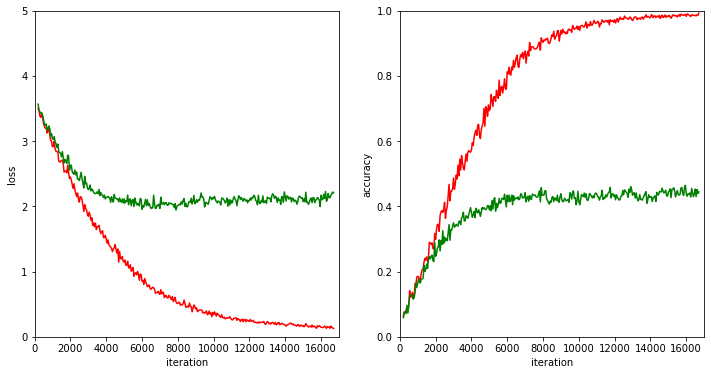

In [14]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,17000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,17000)
acc_graph.set_ylim(0,1)

plt.show() 